**Engy-4390** Nuclear Systems Design and Analysis, UMass Lowell, Chem. Eng. Nuclear Program Fall 2024; Prof. V. F. de Almeida

# Constant Thermal Conductivity, Inhomogeneous Source, and Dirichlet BC

**Student(s):**  Kyle Mills and Billy Manco and Donaita Anglade <br>
**Course:** Engy-4390: Nuclear Systems Design and Analysis  <br>
**Mentor and Collaborator:** Subash Sharma

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**21 Oct 2024**

---
## Table of Contents<a id="toc"></a>
* [Problem Conditions](#conds)
* [Setup](#setup)
* [Test Three](#test)
---

## [Problem Data](#toc)<a id="setup"></a>

Heating power density, $f(x)$, is dependent on position, thermal conductivity, $k$, is a constant:

+ $k = 156 \left [ \frac{W}{mK} \right ]$
+ $f(x) = 206 151+129 400 \, x \; \left [ \frac{W}{m^{3}} \right ]$

and the temperature at the ends of the domain are specified as a Dirichlet BC:

+ $T(a) = 20$ [°C], and $T(b)= 40$ [°C].

## [Setup of FEM](#toc)<a id="test"></a>

In [2]:
'''Domain'''
'''Rayleigh Ritz Method with Lagrange FE Basis Functions'''
x_min = 0     # m
x_max = 0.05  # m

degree = 2  # Degree of the lagrange polinomials used
n_elem = 10 # Number of elements used

In [3]:
'''Domain partition'''
from pyfires import get_domain_partition

In [4]:
'''Parent mapping'''
from pyfires import get_parent_mapping

In [5]:
'''The basis functions'''
from pyfires import get_parent_basis_functions

In [6]:
'''Global basis functions'''
from pyfires import global_basis_function

In [7]:
'''All global basis functions'''
from pyfires import get_global_basis_functions

In [8]:
'''Inner product'''
from pyfires import inner_product

## [Implementing Data](#toc)<a id="test"></a>

In [31]:
'''Thermal conductivity'''
from pyfires import linear_func
from pyfires import plot_func

k_func = linear_func(x_min, x_max, (156.0, 156.0)) # W/mK
k_func = linear_func(x_min, x_max, (31.0, 31.0)) # W/mK

'''Heating Power Density'''
f_func = linear_func(x_min, x_max, (206151.0, 212621.0)) # W/m^3

f_func = linear_func(x_min, x_max, (206.0, 206.0)) # W/m^3

view_plots = False

In [32]:
if view_plots:
    n_plot_pts = 200
    title = 'Thermal Conductivity'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'K [W/mk]'
    plot_func(k_func, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

    title = 'Heating Power Density'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'f [W/m^3]'
    plot_func(f_func, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

In [33]:
'''FEM Solution'''
'''Domain partition'''

domain_partition = get_domain_partition(degree, n_elem, x_min, x_max)
parent_mapping = get_parent_mapping()
parent_basis_functions = get_parent_basis_functions()

phi_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[0]
phi_prime_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[1]

In [34]:
'''Building the lift function'''
u_a = 20 #temperature at point a in degrees C
u_b = 40 #temperature at point b in degrees C

lift_func = linear_func(x_min, x_max, (u_a, u_b)) # C
lift_prime = (u_b-u_a)/(x_max-x_min)
lift_func_prime = linear_func(x_min, x_max, (lift_prime, lift_prime)) # C

view_plots = False

In [35]:
if view_plots:
    n_plot_pts = 200
    title = 'Lift Function'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'T [C]'
    plot_func(lift_func, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

    title = 'Lift Function Prime'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'dT/dx [C/m]'
    plot_func(lift_func_prime, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

In [36]:
#Building of the A matrix
import numpy as np
A_mtrx = np.zeros((len(phi_list), len(phi_list)), dtype=np.float64)
patches = domain_partition[0]
for i in range(len(phi_list)):
    for j in range(len(phi_list)):
        
        phi_i=phi_list[i]
        phi_j=phi_list[j]
        
        phi_prime_i=phi_prime_list[i]
        phi_prime_j=phi_prime_list[j]
        
        h_e=(x_max-x_min)/n_elem
        
        d_x_phi_prime_j = lambda x: k_func(x) * ((2/h_e)*phi_prime_j(x))
        
        prima = lambda x: phi_prime_i(x)*(2/h_e)
        
        A_mtrx[i,j] = inner_product(prima, d_x_phi_prime_j, patches)

In [37]:
'''Build load vector'''
#The load vector
b_vec = np.zeros(len(phi_list), dtype=np.float64)
patches = domain_partition[0]

for i in range(len(phi_list)):
    phi_i=phi_list[i]
    phi_prime_i=phi_prime_list[i]
    
    b_vec[i] = inner_product(f_func, phi_i, patches)
    
    first_term = lambda x: lift_func_prime(x) * k_func(x)
    phi_prima_i = lambda x: phi_prime_i(x)*(2/h_e)
    
    b_vec[i] -= inner_product(first_term, phi_prima_i, patches)

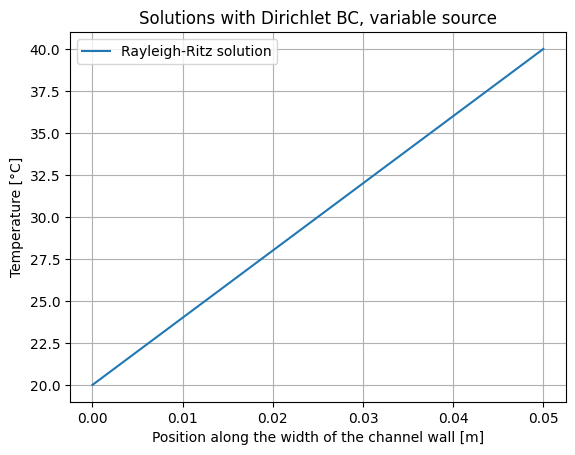

The value of the function at the leftmost end of the domain is: 20.00 [°C].
The value of the function at the rightmost end of the domain is: 40.00 [°C].


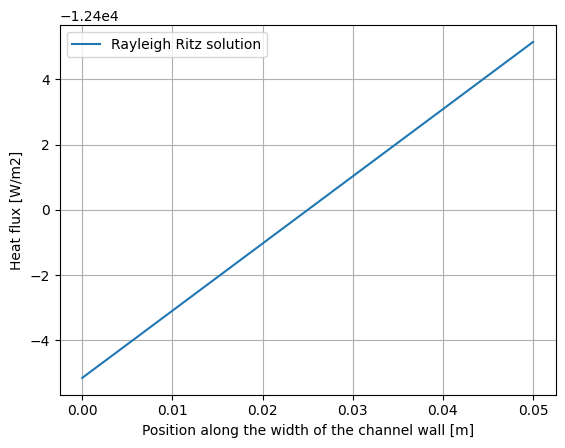

q_na computed =  [-12405.15]
q_nb computed =  [-12394.85]


In [38]:
'''Solution'''
'''Compute optimal coefficient vector'''
import matplotlib.pyplot as plt

c_star_vec = np.linalg.solve(A_mtrx, b_vec)

'''Plot comparison of f and g_best_vec'''
def u_star(x):
    g_x=lift_func(x)
    for (j,phi_i) in enumerate(phi_list):
        g_x=g_x+(c_star_vec[j])*phi_i(x)
    return g_x

def u_star_prime(x):
    g_x=lift_func_prime(x)
    for j in range(len(phi_list)):
        g_x=g_x+(c_star_vec[j])*((2/h_e)*phi_prime_list[j](x))
    return g_x

plt.figure()
plt.plot(np.linspace(x_min,x_max,2000), u_star(np.linspace(x_min,x_max,2000)), label='Rayleigh-Ritz solution')
#plt.plot(np.linspace(x_min,x_max,2000),sol(np.linspace(x_min,x_max,2000)),label='Analytic solution')
plt.xlabel("Position along the width of the channel wall [m]")
plt.title('Solutions with Dirichlet BC, variable source')
plt.ylabel("Temperature [°C]")
plt.legend()
plt.grid()
plt.show()

print('The value of the function at the leftmost end of the domain is: %4.2f [°C].'%u_star(x_min)[0])
print('The value of the function at the rightmost end of the domain is: %4.2f [°C].'%u_star(x_max)[0])

#Plotting the flux
plt.figure()
plt.plot(np.linspace(x_min,x_max,2000),-k_func(np.linspace(x_min,x_max,2000))*u_star_prime((np.linspace(x_min,x_max,2000))),label='Rayleigh Ritz solution')
plt.xlabel("Position along the width of the channel wall [m]")
plt.ylabel("Heat flux [W/m2]")
plt.legend()
plt.grid()
plt.show()

'''Flux at boundary'''
print('q_na computed = ', -k_func(x_min)*u_star_prime(x_min))
print('q_nb computed = ', -k_func(x_max)*u_star_prime(x_max))
#print('q_nb given    = ', q_nb)
#print('flux error [%]= ',(-k_func(x_max)*g_prime(x_max) - q_nb)/q_nb*100)